In [1]:
import numpy as np
import rawpy
import matplotlib.pyplot as plt
import csv
from scipy.stats import linregress

In [25]:
images = "/Users/David_Sauer/Documents/Biophysik/diffusion-analysis/experiments/tinte-blau-april/pictures/"
areas = images + "areas.csv"
bit_depth = 2**12
dilutions = [500,750,1000,2000,4000,8000]
color_desc = {0: "R", 1: "G", 2: "B", 3: "G"} #read out manually 
raw_pattern = [[0,1], [3,2]]
#FIXME: Use relative path instead

In [100]:
def singleColorArray(target_color, arr, posx, posy):
    if target_color == None:
        return arr.mean()
    new_arr = []
    for index_r, row in enumerate(arr):
        for index_c, col in enumerate(row):
            r_ind = index_r + posy
            c_ind = index_c + posx
            color = None 
            if r_ind % 2 == 0:
                if c_ind % 2 == 0:
                    color = 0
                else:
                    color = 1
            else:
                if c_ind % 2 == 0:
                    color = 3
                else:
                    color = 2
            if color_desc[color] == target_color:
                new_arr.append(col)
            else:
                pass
    return np.array(new_arr)

def read(dilution, x, y, xlen, ylen):
    y = y + y%2
    x = x + x%2
    xlen = xlen + xlen%2
    ylen = ylen + ylen%2
    img_data = None
    with rawpy.imread(images+str(dilution)+".DNG") as raw:
        img_data = raw.raw_image.copy()
        black = np.array(raw.black_level_per_channel).mean()
    ret = img_data[y:y+ylen,x:x+xlen]
    return (ret, black)

def get_boundaries(dilution):
    with open(areas) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if row[0] == str(dilution):
                if row[1] == "NA":
                    raise RuntimeError("Areas not defined.")
                return [int(n) for n in row[1:]]
            
def _intensity(dilution, boundaries, color):
    x, y, xlen, ylen, xctrl, yctrl, xlenctrl, ylenctrl = boundaries
    arr_a, black_a = read(dilution, x, y, xlen, ylen)
    arr_c, black_c = read(dilution, xctrl, yctrl, xlenctrl, ylenctrl)
    a_val = bit_depth-(singleColorArray(color, arr_a, x, y).mean() - black_a)
    c_val = bit_depth-(singleColorArray(color, arr_c, xctrl, yctrl).mean() - black_c)
    print(a_val, c_val)
    return (np.log10(a_val/c_val), dilution)

def c_intensity(dilution, color):
    return _intensity(dilution, get_boundaries(dilution), color)[0]

def intensity(dilution):
    #FIXME: Improve performance
    return c_intensity(dilution, None)

In [71]:
intensities = []
concentrations = []

for dil in dilutions:
    intensities.append(intensity(dil))
    concentrations.append(1/dil)

plt.plot(concentrations[1:], intensities[1:])
slope, intercept, r_value, p_value, std_err = linregress(concentrations[1:], intensities[1:])
print("R: {}, p {}".format(r_value, p_value))

R
500
4089.5467 3376.069083820663
750
4052.7285666666667 3356.1141333333335
1000
3923.36112 3603.242048
2000
3717.378311111111 3604.5660888888888
4000
3630.8944 3589.597333333333
8000
3604.318690909091 3642.786488888889
R: 0.9670050740860721, p 0.007158852676609957 


G
500
4083.2375899999997 3192.4240545808966
750
4021.6620416666665 3168.041688888889
1000
3860.58324 3470.708896
2000
3613.853448888889 3468.380311111111
4000
3514.6149875 3457.4725866666668
8000
3482.336031168831 3526.6965333333333
R: 0.9651337786695088, p 0.0077742183365310785 


B
500
4089.31476 3801.0407797270955
750
4011.60415 3805.234844444444
1000
3956.64072 3890.808656
2000
3893.839946666667 3892.7949777777776
4000
3885.067225 3889.0692266666665
8000
3885.3898805194804 3912.223822222222
R: 0.936243630141826, p 0.019139108867911706 




/Users/David_Sauer/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  fig.canvas.print_figure(bytes_io, **kw)


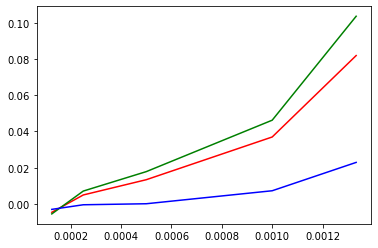

In [103]:
for col in ["R","G","B"]:
    print(col)
    intensities = []
    concentrations = []

    for dil in dilutions:
        print(dil)
        intensities.append(c_intensity(dil, col))
        concentrations.append(1/dil)
    plt.plot(concentrations[1:], intensities[1:], color=col)
    #FIXME: Before plotting convert to lowercase color letter
    slope, intercept, r_value, p_value, std_err = linregress(concentrations[1:], intensities[1:])
    print("R: {}, p {} \n\n".format(r_value, p_value))